In [2]:
import pandas as pd
import pyreadstat
from collections import Counter
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import shap
import numpy as np

In [4]:
data = pd.read_stata("C:/Users/ASUS/Desktop/Harvard/leila_survey/complete_codes/data/V1_qualflags_analysis2_ML.dta")
df, meta = pyreadstat.read_dta("C:/Users/ASUS/Desktop/Harvard/leila_survey/complete_codes/data/V1_qualflags_analysis2_ML.dta")
    
variable_labels = dict(zip(data.columns, meta.column_labels))

In [10]:
relevant_program_data_dummies = pd.get_dummies(data)
# Replace characters in columns that don't work for modeling

new_cols = []
for item in relevant_program_data_dummies.columns:
    if '>' in item:
       item = item.replace('>', 'greater')
    if '<' in item:
       item = item.replace('<', 'less')
    if ',' in item:
       item = item.replace(',', '_')
    new_cols.append(item)

relevant_program_data_dummies.columns = new_cols
relevant_program_data_dummies.head()

,f_size_n,f_hq_na,f_mne,f_mne_us,f_mne_nonus,f_sub_asia,f_sub_africa,f_sub_northamerica,f_sub_southamerica,f_sub_europe,...,clusplot2_No Skill Gap,sk_gapcertainty_Not confident at all,sk_gapcertainty_Not very confident,sk_gapcertainty_Somewhat confident,sk_gapcertainty_Very confident,sk_gapcertainty_Completely certain,tr_clusplot2_Digital+Cognitive,tr_clusplot2_Everything,tr_clusplot2_Soft,tr_clusplot2_Digital+Soft
0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,True,False,False,False,False,False,True,False,False,False
1,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,True,False,True,False,False,False
2,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,True,False,False,True,False,False,False,False,False,True
3,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,True,False,False,True,False
4,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,True,False,False,False,False,True,False


## 2 Cluster Creation

C:\Users\ASUS\anaconda3\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


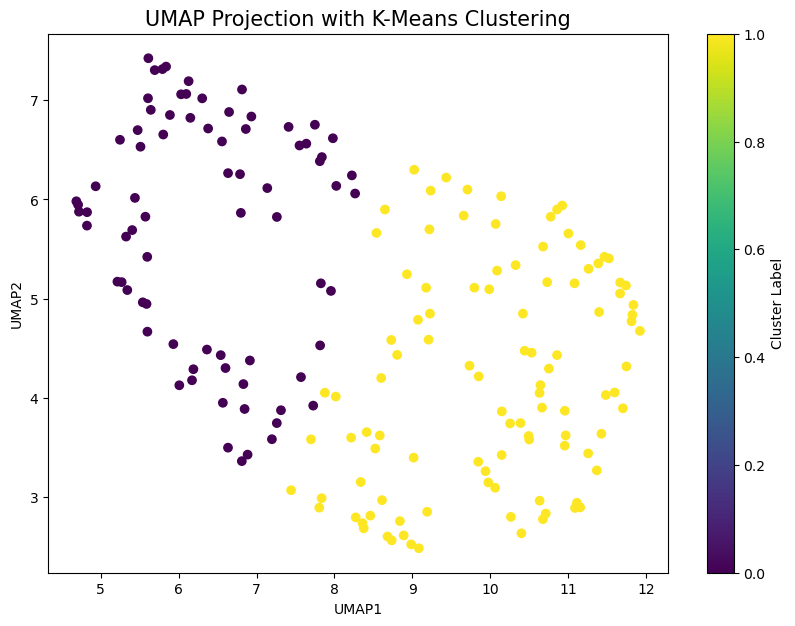

Cluster labels:
 [0 1 0 0 0 0 0 0 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 0 1 1
 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 0 0 1 1 0 1 1
 1 1 1 1 0 0 0 1 0 1 1 0 1 0 1 0 0 0 1 0 1 0 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0
 0 1 0 0 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1
 1 1 0 1 1 0 0 1 0 1 0 0 1 0 1 0 0 1 1 1 0 0 1 0 1 1 0 1 1 1 0 1]


In [12]:
import umap.umap_ as umap
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Step 1: UMAP for dimensionality reduction
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(relevant_program_data_dummies.dropna())  # UMAP reduces the data to 2D

# Step 2: Apply K-Means clustering to the UMAP-reduced data
n_clusters = 2  # Choose the number of clusters (e.g., 3 clusters)
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(embedding)  # Perform clustering on the UMAP output

# Step 3: Visualize the UMAP projection and color by cluster assignment
plt.figure(figsize=(10, 7))
plt.scatter(embedding[:, 0], embedding[:, 1], c=cluster_labels, cmap='viridis')  # Color by cluster
plt.colorbar(label='Cluster Label')
plt.title('UMAP Projection with K-Means Clustering', fontsize=15)
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.show()

# Output the cluster labels to check assignments
print("Cluster labels:\n", cluster_labels)


C:\Users\ASUS\anaconda3\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there 

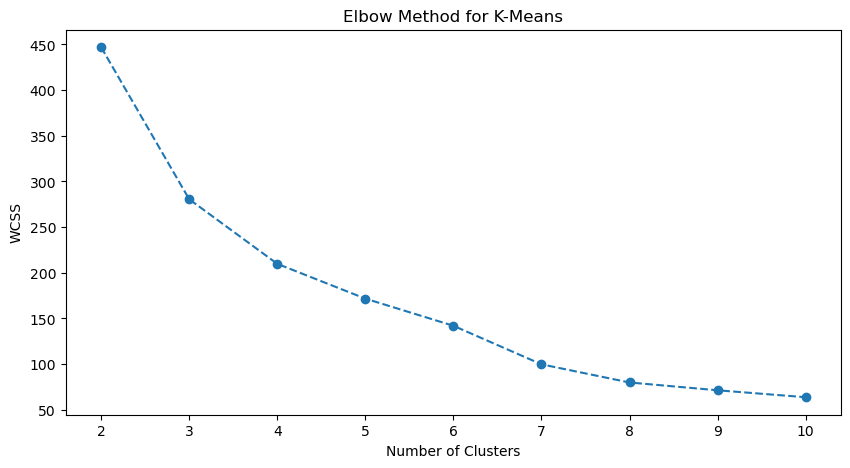

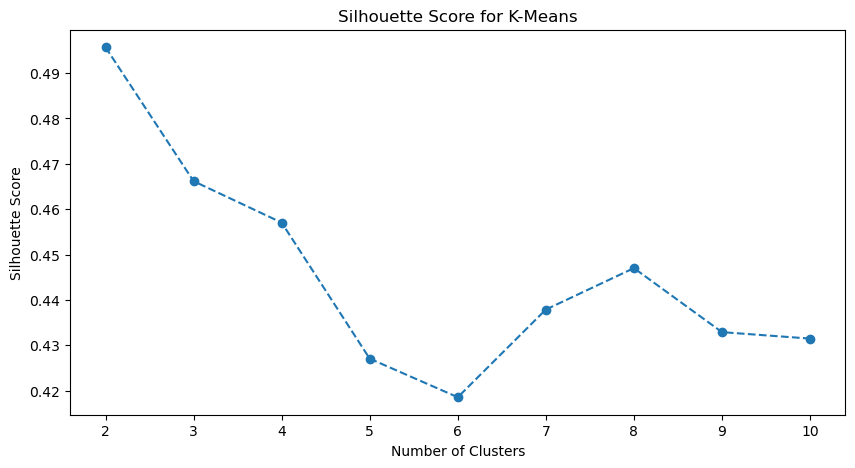

In [22]:
import umap
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Step 1: UMAP for dimensionality reduction (assuming this is already done)
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(relevant_program_data_dummies.dropna())

# -------------------------------
# Elbow Method for K-Means: 3 CLUSTERS OPTIMAL CHOICE USING BOTH!!! 
# -------------------------------
wcss_kmeans = []
silhouette_kmeans = []

# Try different numbers of clusters for K-Means
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels_kmeans = kmeans.fit_predict(embedding)
    wcss_kmeans.append(kmeans.inertia_)  # Within-cluster sum of squares (WCSS)
    
    # Silhouette Score
    silhouette_avg = silhouette_score(embedding, cluster_labels_kmeans)
    silhouette_kmeans.append(silhouette_avg)

# Plotting the Elbow Method (K-Means)
plt.figure(figsize=(10, 5))
plt.plot(range(2, 11), wcss_kmeans, marker='o', linestyle='--', label='K-Means WCSS')
plt.title('Elbow Method for K-Means')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

# Plotting the Silhouette Score for K-Means
plt.figure(figsize=(10, 5))
plt.plot(range(2, 11), silhouette_kmeans, marker='o', linestyle='--', label='K-Means Silhouette')
plt.title('Silhouette Score for K-Means')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()


In [20]:
import umap.umap_ as umap
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
#from sklearn_extra.cluster import KMedoids  # For K-Medoids clustering

# Step 1: UMAP for dimensionality reduction
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(relevant_program_data_dummies.dropna())  # UMAP reduces the data to 2D

# Step 2: Apply K-Means clustering to the UMAP-reduced data
n_clusters = 2  # Choose the number of clusters (e.g., 3 clusters)
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels_kmeans = kmeans.fit_predict(embedding)  # Perform clustering on the UMAP output

# Step 3: Apply K-Medoids clustering to the UMAP-reduced data
#kmedoids = KMedoids(n_clusters=n_clusters, random_state=42, metric='euclidean')
#cluster_labels_kmedoids = kmedoids.fit_predict(embedding)  # Perform clustering on the UMAP output

# -------------------------
# Saving clusters to dataset
# -------------------------

# Make sure to drop missing values from the original data to match the reduced embedding data
# This is important because UMAP was fit on the data without missing values.
relevant_program_data_dummies_clusters = relevant_program_data_dummies.dropna().copy()

# Step 4: Add the cluster labels from both K-Means and K-Medoids to the original DataFrame
relevant_program_data_dummies_clusters['KMeans_Cluster'] = cluster_labels_kmeans
#relevant_program_data_dummies_clusters['KMedoids_Cluster'] = cluster_labels_kmedoids

# Step 5: Save the DataFrame to a new CSV file (or any format you prefer)
relevant_program_data_dummies_clusters.to_csv('clusters_2_construction.csv', index=False)

# You can also inspect the first few rows to check the clusters
print(relevant_program_data_dummies_clusters.head())

C:\Users\ASUS\anaconda3\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


    f_size_n  f_hq_na  f_mne  f_mne_us  f_mne_nonus  f_sub_asia  f_sub_africa  \
7        2.0      1.0    0.0       0.0          0.0         0.0           0.0   
25       5.0      1.0    1.0       1.0          0.0         0.0           0.0   
33       4.0      1.0    0.0       0.0          0.0         0.0           0.0   
35       2.0      1.0    0.0       0.0          0.0         0.0           0.0   
49       2.0      1.0    1.0       1.0          0.0         0.0           0.0   

    f_sub_northamerica  f_sub_southamerica  f_sub_europe  ...  \
7                  0.0                 0.0           0.0  ...   
25                 1.0                 0.0           0.0  ...   
33                 0.0                 0.0           0.0  ...   
35                 0.0                 0.0           0.0  ...   
49                 1.0                 0.0           0.0  ...   

    sk_gapcertainty_Not confident at all  sk_gapcertainty_Not very confident  \
7                                  False  

## 3 Clusters Creation

C:\Users\ASUS\anaconda3\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


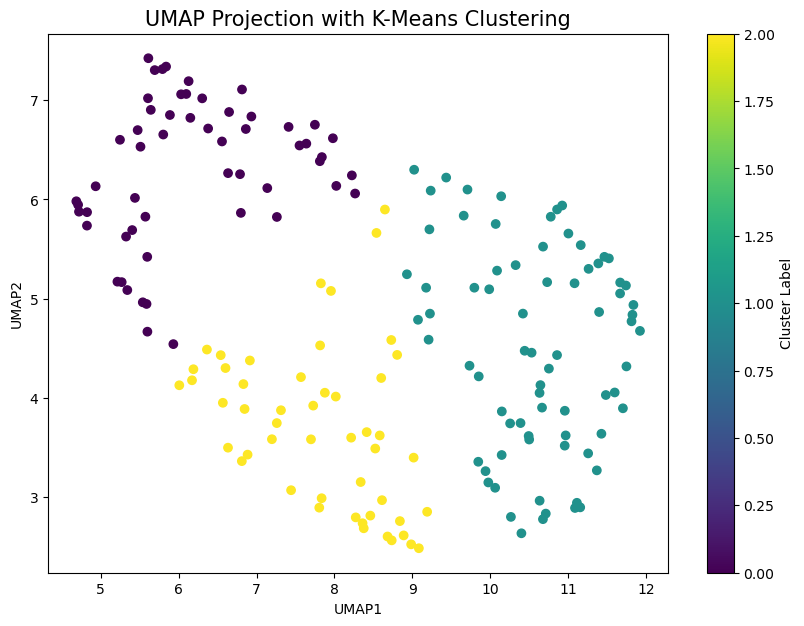

Cluster labels:
 [0 1 2 0 0 2 2 2 1 0 2 1 2 0 1 2 1 1 2 2 1 2 1 1 2 1 1 1 2 1 2 0 0 1 0 1 2
 1 0 1 0 2 0 0 1 2 0 1 0 0 2 2 1 1 1 1 1 2 2 2 2 2 0 2 0 0 1 0 2 1 1 0 1 2
 1 2 1 2 0 0 2 1 2 2 2 2 2 0 1 0 2 0 1 0 2 0 0 0 0 0 1 1 0 1 1 0 0 2 0 0 0
 0 2 0 0 1 2 0 2 0 0 0 0 2 0 1 1 1 1 1 1 1 1 1 1 1 2 2 1 1 1 2 2 1 1 1 1 1
 1 1 2 1 1 0 0 1 0 1 0 0 1 2 1 0 0 1 1 1 0 2 1 0 1 1 2 1 1 1 2 1]


In [27]:
import umap.umap_ as umap
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Step 1: UMAP for dimensionality reduction
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(relevant_program_data_dummies.dropna())  # UMAP reduces the data to 2D

# Step 2: Apply K-Means clustering to the UMAP-reduced data
n_clusters = 3  # Choose the number of clusters (e.g., 3 clusters)
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(embedding)  # Perform clustering on the UMAP output

# Step 3: Visualize the UMAP projection and color by cluster assignment
plt.figure(figsize=(10, 7))
plt.scatter(embedding[:, 0], embedding[:, 1], c=cluster_labels, cmap='viridis')  # Color by cluster
plt.colorbar(label='Cluster Label')
plt.title('UMAP Projection with K-Means Clustering', fontsize=15)
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.show()

# Output the cluster labels to check assignments
print("Cluster labels:\n", cluster_labels)


In [29]:
import umap.umap_ as umap
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
#from sklearn_extra.cluster import KMedoids  # For K-Medoids clustering

# Step 1: UMAP for dimensionality reduction
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(relevant_program_data_dummies.dropna())  # UMAP reduces the data to 2D

# Step 2: Apply K-Means clustering to the UMAP-reduced data
n_clusters = 3  # Choose the number of clusters (e.g., 3 clusters)
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels_kmeans = kmeans.fit_predict(embedding)  # Perform clustering on the UMAP output

# Step 3: Apply K-Medoids clustering to the UMAP-reduced data
#kmedoids = KMedoids(n_clusters=n_clusters, random_state=42, metric='euclidean')
#cluster_labels_kmedoids = kmedoids.fit_predict(embedding)  # Perform clustering on the UMAP output

# -------------------------
# Saving clusters to dataset
# -------------------------

# Make sure to drop missing values from the original data to match the reduced embedding data
# This is important because UMAP was fit on the data without missing values.
relevant_program_data_dummies_clusters = relevant_program_data_dummies.dropna().copy()

# Step 4: Add the cluster labels from both K-Means and K-Medoids to the original DataFrame
relevant_program_data_dummies_clusters['KMeans_Cluster'] = cluster_labels_kmeans
#relevant_program_data_dummies_clusters['KMedoids_Cluster'] = cluster_labels_kmedoids

# Step 5: Save the DataFrame to a new CSV file (or any format you prefer)
relevant_program_data_dummies_clusters.to_csv('clusters_3_construction.csv', index=False)

# You can also inspect the first few rows to check the clusters
print(relevant_program_data_dummies_clusters.head())

C:\Users\ASUS\anaconda3\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


    f_size_n  f_hq_na  f_mne  f_mne_us  f_mne_nonus  f_sub_asia  f_sub_africa  \
7        2.0      1.0    0.0       0.0          0.0         0.0           0.0   
25       5.0      1.0    1.0       1.0          0.0         0.0           0.0   
33       4.0      1.0    0.0       0.0          0.0         0.0           0.0   
35       2.0      1.0    0.0       0.0          0.0         0.0           0.0   
49       2.0      1.0    1.0       1.0          0.0         0.0           0.0   

    f_sub_northamerica  f_sub_southamerica  f_sub_europe  ...  \
7                  0.0                 0.0           0.0  ...   
25                 1.0                 0.0           0.0  ...   
33                 0.0                 0.0           0.0  ...   
35                 0.0                 0.0           0.0  ...   
49                 1.0                 0.0           0.0  ...   

    sk_gapcertainty_Not confident at all  sk_gapcertainty_Not very confident  \
7                                  False  

C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
